In [154]:
import ROOT
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import glob
%jsroot
from tqdm import tqdm
from array import array
import itertools
from collections import defaultdict
from collections import Counter
import pandas as pd
import random
import pickle

import scipy.stats as stats
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from scipy.spatial import KDTree

import torch
from torch.utils.data import Dataset
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
from torch_geometric.nn import DynamicEdgeConv, TransformerConv, Set2Set, GlobalAttention
from torch_geometric.data import Batch
from torch.nn import Sequential, Linear, ReLU
from torch_cluster import radius_graph
from torch_geometric.nn import knn_graph
import torch.nn.functional as F
from math import acos, degrees

from torch import nn
from torch_geometric.nn import (
    DynamicEdgeConv,
    GATConv,
    global_mean_pool,
    knn_graph
)
from torch_geometric.utils import to_dense_batch
import matplotlib.patches as mpatches
from torch.optim.lr_scheduler import StepLR,ReduceLROnPlateau
from torch_geometric.nn import JumpingKnowledge
import imageio

In [2]:
layout_file = ROOT.TFile("/mnt/e/testML/pie/run00000-00.root")
geohelper = layout_file.Get("PIMCGeoHelper")
layout = geohelper.GetLayout("CALORIMETER", "TP2")

In [3]:
pdg_to_idx = {pdg: i for i, pdg in enumerate([211,-13,-11,11,98105])}
# Bitmask constants (1 bit per particle type)
PION      = 0b00001  # 1
MUON      = 0b00010  # 2
POSITRON  = 0b00100  # 4
ELECTRON  = 0b01000  # 8
OTHER     = 0b10000  # 16

def pdg_to_mask(pdg_id):
    if pdg_id == 211: return PION
    elif pdg_id == -13: return MUON
    elif pdg_id == -11:       return POSITRON
    elif pdg_id == 11:        return ELECTRON
    else:                     return OTHER

MASK_TO_PDG = {
    0b00001: 211,    # pion
    0b00010: -13,     # muon
    0b00100: -11,    # positron
    0b01000: 11,     # electron
    0b10000: 98105    # other
    }

def decode_mask(mask):
    """
    Given a bitmask, return a list of PDG IDs it represents.
    """
    return [pdg for bit, pdg in MASK_TO_PDG.items() if mask & bit]

In [4]:
def smear(energy,energy_resolution):
    stdv = energy * energy_resolution
    smeared_energy = energy + np.random.normal(0,stdv)
    return smeared_energy

In [5]:
MERGE_WINDOW = 2
GROUP_WINDOW = 1
def group_hits_in_time(allHits, time_window_ns=GROUP_WINDOW):
    """
    Groups hits into clusters where each hit is within `time_window_ns`
    of the first hit in the group.

    Parameters:
        allHits: dict mapping pixelID -> list of np.array hits
                 where each hit is [x/y, z, stripType, energy, time, pdg, eventNum]
        time_window_ns: max allowed time separation within a group

    Returns:
        List of groups, where each group is a list of np.ndarray hits (no pixelID)
    """
    # Flatten all hits into a list of hit_array
    hit_list = []
    for hits in allHits.values():
        hit_list.extend(hits)

    # Sort hits by time (index 4)
    hit_list.sort(key=lambda hit: hit[4])

    #print(len(allHits), len(hit_list), "hits in total")

    groups = []
    current_group = []
    group_time = None

    for hit in hit_list:
        time = hit[4]
        if not current_group:
            current_group.append(hit)
            group_time = time
        elif abs(time - group_time) <= time_window_ns:
            current_group.append(hit)
            group_time = time
        else:
            total_energy = sum(h[3] for h in current_group)
            group_with_energy = [np.append(h, total_energy/1) for h in current_group]
            random.shuffle(group_with_energy)
            groups.append(np.array(group_with_energy))
            #random.shuffle(current_group)
            #groups.append(np.array(current_group))
            current_group = [hit]
            group_time = time

    if current_group:
        total_energy = sum(h[3] for h in current_group)
        group_with_energy = [np.append(h, total_energy/1) for h in current_group]
        random.shuffle(group_with_energy)
        groups.append(np.array(group_with_energy))
        #random.shuffle(current_group)
        #groups.append(np.array(current_group))
    #print([print(group) for group in groups])

    return groups

In [6]:
def groupID(groupList):
    """
    This function takes in a list of groups of hits, and returns the unique PDG IDs
    associated with each group, based on bitmask encoding. A PDG ID is kept only if it
    appears in at least two hits in the group; if none do, all are kept.
    """
    unique_pdg_per_group = []

    for group in groupList:
        all_decoded_pdgs = []
        for hit in group:
            mask = int(hit[5])
            all_decoded_pdgs.extend(decode_mask(mask))

        pdg_counts = Counter(all_decoded_pdgs)
        unique_pdgs = [pdg for pdg, count in pdg_counts.items() if count >= 2]

        if not unique_pdgs:
            unique_pdgs = list(pdg_counts.keys())

        unique_pdg_per_group.append(unique_pdgs)

    return unique_pdg_per_group

In [7]:
def groupMerger(groupList, prob=0.1):
    if len(groupList) != 3:
        return groupList

    if random.random() < prob:
        start_idx = random.choice([0, 1])
        idx1, idx2 = start_idx, start_idx + 1

        group1 = groupList[idx1]
        group2 = groupList[idx2]

        merged_dict = {}

        # Collect all hits from both groups
        for hit in np.concatenate((group1, group2)):
            # Define unique position key
            key = (hit[0], hit[1], int(hit[2]))  # (coord, z, stripType)

            if key not in merged_dict:
                merged_dict[key] = hit.copy()
            else:
                existing_hit = merged_dict[key]
                existing_hit[3] += hit[3]  # merge energy
                existing_hit[4] = min(existing_hit[4], hit[4])  # keep earliest time
                existing_hit[5] = int(existing_hit[5]) | int(hit[5])  # merge pdg bitmasks

        # Final merged array
        merged = np.array(list(merged_dict.values()))
        np.random.shuffle(merged)

        # Replace original groups
        for idx in sorted([idx1, idx2], reverse=True):
            groupList.pop(idx)
        groupList.insert(idx1, merged)

    return groupList

In [8]:
kPidif  = 0x0000000010
def process_time_groups(sample_chains, max_events=10000, geohelper=geohelper, enhanceMerge=False, pionstop=False, positronAngle=False):
    """
    Processes sample chains to extract time-grouped hits and their labels per event.

    Parameters:
        sample_chains (dict): Mapping of run -> TChain or iterable of entries.
        geohelper: Geometry helper with GetX/Y/Z and GetPsi methods.
        smear (func): Smearing function that takes (energy, resolution).
        group_hits_in_time (func): Function to time-group hits.
        groupID (func): Function to generate group labels from time groups.

    Returns:
        eventTimeGroups (dict): Mapping event index -> grouped hit arrays.
        timeGroupLabels (dict): Mapping event index -> group label list.
    """
    MERGE_WINDOW = 2
    eventTimeGroups = np.empty(max_events, dtype=object)
    timeGroupLabels = np.empty(max_events, dtype=object)
    if pionstop:
        pionStops = np.empty(max_events, dtype=object)
    if positronAngle:
        positronAngles = np.empty(max_events, dtype=object)

    eventNumber = 0

    events_per_chain = max_events // len(sample_chains)

    for run, chain in tqdm(sample_chains.items()):
        events_taken = 0

        triggered = 0
        
        for entry in chain:

            if events_taken >= events_per_chain or eventNumber >= max_events:
                break

            eventType = int(entry.info.GetType())
            if eventType & kPidif:
                # Skip events that are of type kPidif
                continue
                
            allHits = {}

            triggered = 0
            for upstream in entry.upstream:
                if upstream.GetUpstreamID() == 99999:
                    energyDTAR = upstream.GetTotalEnergyDeposit()
                    if energyDTAR > 1:
                        triggered = 1
                    
            if not triggered:
                eventTimeGroups[eventNumber] = []
                timeGroupLabels[eventNumber] = []
                if pionstop:
                    pionStops[eventNumber] = []
                if positronAngle:
                    positronAngles[eventNumber] = []
                continue

            pion_in_atar = 0
            pion_stop_position = (-100, -100, -100)
            pion_time = 0

            thetaInit, phiInit = -1000, -1000
            positron_in_atar = 0

            evil_event= 0

            merged_pdgs_counter = {}
            merged_pixels = []

            for decay in entry.decay:
                nD = decay.GetNDaughters()
                if run == 'michel':
                    if nD != 3:
                        breaker = 1
                        continue
                    if (nD == 3):
                        #decayTime = decay.GetTime()
                        #truthMom = mom.R()
                        #truthEnergy = np.sqrt((ELECTRON_MASS ** 2) + truthMom**2) + ELECTRON_MASS
                        mom = decay.GetDaughterMomAt(2)
                        #pdg = decay.GetDaughterPDGIDAt(2)
                        thetaInit = mom.Theta()
                        phiInit = mom.Phi()
                        continue
                elif run == 'pie':
                    if nD != 2:
                        breaker = 1
                        continue
                    if (nD == 2):
                        #decayTime = decay.GetTime()
                        #truthMom = mom.R()
                        #truthEnergy = np.sqrt((ELECTRON_MASS ** 2) + truthMom**2) + ELECTRON_MASS
                        mom = decay.GetDaughterMomAt(1)
                        #pdg = decay.GetDaughterPDGIDAt(1)
                        thetaInit = mom.Theta()
                        phiInit = mom.Phi()
                        continue
            
            for atarHit in entry.atar:
                pdg = atarHit.GetPDGID()
                if pdg not in [211, -11, -13, 11]:
                    continue
            
                if pdg not in [211,-11,-13,11]:
                    print('evil')
                    evil_event = 1

                pdg_binary = pdg_to_mask(pdg)

                hitTime = atarHit.GetTime() + np.random.normal(0, 0.2)
                pixelID = atarHit.GetPixelID()
                edep = atarHit.GetEdep()
                energySmeared = smear(edep, 0.15)
                stripType = abs(abs(geohelper.GetPsi(pixelID)) - 0.0) > 0.01

                coord = geohelper.GetY(pixelID) if stripType else geohelper.GetX(pixelID)
                z = geohelper.GetZ(pixelID)
                hit = np.array([coord, z, stripType, energySmeared, hitTime, pdg_binary, eventNumber])

                if pdg == 211:
                    pion_in_atar = 1
                    if pionstop:
                        if atarHit.GetTime() > pion_time:
                            pion_time = atarHit.GetTime()
                            pion_stop_position = ((atarHit.GetX0()+atarHit.GetX1())/2, (atarHit.GetY0()+atarHit.GetY1())/2, (atarHit.GetZ0()+atarHit.GetZ1())/2)

                if pdg == -11:
                    positron_in_atar = 1


                if pixelID in allHits:
                    merged = False
                    for existing_hit in allHits[pixelID]:
                        if abs(existing_hit[4] - hitTime) < MERGE_WINDOW:
                            existing_hit[3] += energySmeared
                            existing_hit[5] = int(existing_hit[5]) | int(pdg_binary)
                            if pixelID not in merged_pixels:
                                merged_pixels.append(pixelID)
                            merged = True
                            break
                    if not merged:
                        allHits[pixelID].append(hit)
                else:
                    allHits[pixelID] = [hit]

            if len(allHits) < 10:
                evil_event = 1

            if ((not pion_in_atar) or evil_event or (not positron_in_atar)):
                eventTimeGroups[eventNumber] = []
                timeGroupLabels[eventNumber] = []
                if pionstop:
                    pionStops[eventNumber] = []
                if positronAngle:
                    positronAngles[eventNumber] = []
                continue
            
            #if len(allHits) > 200:
            #    print(len(allHits), "hits in event", eventNumber, "run", run)

            # Time-grouping
            groups = group_hits_in_time(allHits)

            #for group in groups:
            #    if len(group) > 200:
            #        print(len(group), "hits in group", eventNumber, "run", run)
                
            if enhanceMerge:
                groups = groupMerger(groups,0.25)

            groupLabels = groupID(groups)

            eventTimeGroups[eventNumber] = groups
            timeGroupLabels[eventNumber] = groupLabels
            if pionstop:
                pionStops[eventNumber] = pion_stop_position
            if positronAngle:
                positronAngles[eventNumber] = [thetaInit, phiInit]

            events_taken += 1
            eventNumber += 1

    # Find indices of empty events
    empty_indices = [i for i, groups in enumerate(eventTimeGroups) if len(groups) == 0]
    
    # Convert to NumPy arrays with object dtype to allow deletion by index
    eventTimeGroupsCleaned = np.array(eventTimeGroups, dtype=object)
    timeGroupLabelsCleaned = np.array(timeGroupLabels, dtype=object)
    pionStopsCleaned = np.array(pionStops, dtype=object) if pionstop else None
    positronAnglesCleaned = np.array(positronAngles, dtype=object) if positronAngle else None
    eventIndexCleaned = np.array(list(range(max_events)))
    
    # Remove empty events
    eventTimeGroupsCleaned = np.delete(eventTimeGroupsCleaned, empty_indices)
    timeGroupLabelsCleaned = np.delete(timeGroupLabelsCleaned, empty_indices)
    eventIndexCleaned = np.delete(eventIndexCleaned, empty_indices)
    pionStopsCleaned = np.delete(pionStopsCleaned, empty_indices) if pionstop else None
    positronAnglesCleaned = np.delete(positronAnglesCleaned, empty_indices) if positronAngle else None

    flat_arr = []
    group_index_dict = {}
    
    for event_idx, event in enumerate(timeGroupLabelsCleaned):
        for group_idx, group in enumerate(event):
            flat_arr.append(group)
            flat_index = len(flat_arr) - 1
            group_index_dict[flat_index] = (event_idx, group_idx)

    if pionstop and not positronAngle:
        return eventTimeGroupsCleaned, timeGroupLabelsCleaned, eventIndexCleaned, group_index_dict, pionStopsCleaned
    elif positronAngle:
        return eventTimeGroupsCleaned, timeGroupLabelsCleaned, eventIndexCleaned, group_index_dict, pionStopsCleaned, positronAnglesCleaned
    else:
        return eventTimeGroupsCleaned, timeGroupLabelsCleaned, eventIndexCleaned, group_index_dict

In [9]:
class GroupDatasetFlat(Dataset):
    def __init__(self, event_groups, group_labels):
        self.groups = list(itertools.chain.from_iterable(event_groups))
        self.labels = list(itertools.chain.from_iterable(group_labels))

    def __len__(self):
        return len(self.groups)

    def __getitem__(self, idx):
        group = np.array(self.groups[idx])          # ensure ndarray
        coords = group[:, 0]
        zs = group[:, 1]
        strip_types = group[:, 2].astype(int)
        energy = group[:, 3]
        time = group[:, 4]
        true_pdgs = group[:, 5]
        event_number = group[:, 6]
        #group_E = group[:, 7][0]
        group_E = group[:, 7]

        # One-hot encode strip type
        view0 = (strip_types == 0).astype(float)
        view1 = (strip_types == 1).astype(float)

        #x = torch.tensor(np.stack([coords, zs, energy, view0, view1], axis=1), dtype=torch.float)
        x = torch.tensor(np.stack([coords, zs, energy, view0, view1, group_E], axis=1), dtype=torch.float)

        # Output: one-hot vector for multi-label classification
        y = torch.zeros(3, dtype=torch.float) # 3 for pion, muon, positron
        for pdg in self.labels[idx]:
            if pdg == 11:
                pdg = -11
            y[pdg_to_idx[pdg]] = 1.0

        pdg_id = torch.tensor(true_pdgs, dtype=torch.float)
        event_id = torch.tensor(event_number, dtype=torch.float)
        group_id = torch.tensor(idx, dtype=torch.int)
        #group_energy = torch.tensor([[group_E]], dtype=torch.float)

        #return Data(x=x,  y=y, pdg_id = pdg_id, group_id=group_id, event_id=event_id, group_energy=group_energy)
        return Data(x=x,  y=y, pdg_id = pdg_id, group_id=group_id, event_id=event_id)

In [10]:
class FullTransformerBlock(nn.Module):
    def __init__(self, hidden_channels, heads, dropout):
        super().__init__()
        self.attn = TransformerConv(
            in_channels=hidden_channels,
            out_channels=hidden_channels // heads,
            heads=heads,
            dropout=dropout,
            concat=True,
            beta=True,
            edge_dim=4
        )
        self.norm1 = nn.LayerNorm(hidden_channels)
        self.ffn = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels * 4),
            nn.ReLU(),
            nn.Linear(hidden_channels * 4, hidden_channels)
        )
        self.norm2 = nn.LayerNorm(hidden_channels)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index, edge_attr=None):
        y = self.attn(x, edge_index, edge_attr)
        x = self.norm1(x + self.dropout(y))
        y2 = self.ffn(x)
        x = self.norm2(x + self.dropout(y2))
        return x

class GroupClassifier(nn.Module):
    def __init__(self, in_channels, hidden_channels, heads=4, dropout=0.2):
        super().__init__()
        self.lin_embed = nn.Linear(in_channels, hidden_channels)
        self.block1    = FullTransformerBlock(hidden_channels, heads, dropout)
        self.block2    = FullTransformerBlock(hidden_channels, heads, dropout)
        self.pool      = GlobalAttention(
            gate_nn=nn.Sequential(
                nn.Linear(hidden_channels, 64),
                nn.ReLU(),
                nn.Linear(64, 1)
            )
        )
        self.output = nn.Sequential(
            nn.Linear(hidden_channels + 1, hidden_channels), # extra 1 for group_energy
            nn.ReLU(),
            nn.Linear(hidden_channels, 3) # 3 for pion, muon, positron
        )

    def forward(self, data):
        x, batch = self.lin_embed(data.x), data.batch

        # Build a complete graph within each batch element
        edge_indices = []
        for event_id in torch.unique(batch):
            mask = batch == event_id
            idx = mask.nonzero(as_tuple=True)[0]
            num = idx.size(0)
            row = torch.arange(num, device=idx.device).repeat_interleave(num)
            col = torch.arange(num, device=idx.device).repeat(num)
            mask_nc = row != col
            ei = torch.stack([idx[row[mask_nc]], idx[col[mask_nc]]], dim=0)
            edge_indices.append(ei)

        edge_index = torch.cat(edge_indices, dim=1)  # shape: [2, E]

        x = self.block1(x, edge_index)
        x = self.block2(x, edge_index)
        x_group = self.pool(x, batch)

        # Append group_energy to pooled group features
        group_energy = data.group_energy  # shape: [batch_size, 1]
        #group_energy = group_energy.unsqueeze(1)
        x_combined = torch.cat([x_group, group_energy], dim=1)  # [batch_size, hidden_channels + 1]

        out = self.output(x_combined)

        return out  

In [11]:
class GroupClassifier(nn.Module):
    def __init__(self, in_channels, hidden_channels, heads=4, num_blocks=2, dropout=0.2):
        super().__init__()
        # Input embedding
        self.lin_embed = nn.Linear(in_channels, hidden_channels)

        # Stacked Transformer blocks (edge-aware)
        self.blocks = nn.ModuleList([
            FullTransformerBlock(hidden_channels, heads, dropout) for _ in range(num_blocks)
        ])

        # Jumping Knowledge across all blocks
        self.jk_layer = JumpingKnowledge(mode='cat')
        jk_output_channels = hidden_channels * num_blocks

        # Global Attention pooling
        self.pool = GlobalAttention(
            gate_nn=nn.Sequential(
                nn.Linear(jk_output_channels, 64),
                nn.ReLU(),
                nn.Linear(64, 1)
            )
        )

        # Final classifier (append group_energy)
        self.output = nn.Sequential(
            nn.Linear(jk_output_channels, hidden_channels * 2), # extra 1 for group_energy
            nn.ReLU(),
            nn.Linear(hidden_channels * 2, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 3)  # pion, muon, positron
        )

    def forward(self, data):
        x_raw = data.x
        x = self.lin_embed(x_raw)         # [N, hidden_channels]
        batch = data.batch                # [N]

        # ---- Build complete graph per batch element ----
        edge_indices = []
        for event_id in torch.unique(batch):
            mask = batch == event_id
            idx = mask.nonzero(as_tuple=True)[0]
            num = idx.size(0)
            row = torch.arange(num, device=idx.device).repeat_interleave(num)
            col = torch.arange(num, device=idx.device).repeat(num)
            mask_nc = row != col
            ei = torch.stack([idx[row[mask_nc]], idx[col[mask_nc]]], dim=0)
            edge_indices.append(ei)

        edge_index = torch.cat(edge_indices, dim=1)  # [2, E]

        # ---- Build edge attributes ----
        pos2d = x_raw[:, :2]                          # first 2 coords
        delta = pos2d[edge_index[1]] - pos2d[edge_index[0]]  # [E, 2]

        energy = x_raw[:, 2]
        dE = (energy[edge_index[1]] - energy[edge_index[0]]).unsqueeze(1)  # [E, 1]

        view0, view1 = x_raw[:, 3], x_raw[:, 4]
        same_view = ((view0[edge_index[1]] * view0[edge_index[0]]) +
                     (view1[edge_index[1]] * view1[edge_index[0]])).unsqueeze(1)  # [E, 1]

        edge_attr = torch.cat([delta, dE, same_view], dim=1)  # [E, 4]

        # ---- Transformer blocks with JumpingKnowledge ----
        layer_outputs = []
        for block in self.blocks:
            x = block(x, edge_index, edge_attr)  # use edge_attr here
            layer_outputs.append(x)

        xjk = self.jk_layer(layer_outputs)       # [N, hidden_channels * num_blocks]

        # ---- Pool to group-level ----
        x_group = self.pool(xjk, batch)          # [B, hidden_channels * num_blocks]

        return self.output(x_group)   

In [12]:
def compute_multilabel_loss_and_accuracy(output, target, criterion=None, threshold=0.5):
    if criterion is None:
        criterion = torch.nn.BCEWithLogitsLoss()

    loss = criterion(output, target)

    # Convert logits to probabilities
    probs = torch.sigmoid(output)

    # Binary predictions using threshold
    pred = (probs > threshold).float()

    # Exact match accuracy: all labels must be correct
    exact_matches = (pred == target).all(dim=1)
    acc = exact_matches.float().mean()

    return loss, acc

In [25]:
def train_multilabel_model(model, loader, optimizer, detailed_tracking=False, num_epochs=10):
    """
    Trains a multi-label classification model.

    Parameters:
        model (torch.nn.Module): The model to train.
        loader (DataLoader): DataLoader providing training data.
        optimizer (torch.optim.Optimizer): Optimizer for updating model parameters.
        compute_multilabel_loss_and_accuracy (func): Function that returns (loss, accuracy) given predictions and targets.
        num_epochs (int): Number of training epochs to run.

    Returns:
        history (list of dict): List containing training loss, accuracy, and label counts per epoch.
    """
    history = []

    device=next(model.parameters()).device

    for epoch in range(1, num_epochs + 1):
        model.train()
        total_loss = 0
        total_acc = 0
        total_label_counts = torch.zeros(3, device=device) # 3 for pion, muon, positron

        if detailed_tracking:
            truth_vals = []
            predictions = []

        for data in loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)

            target = data.y.float().reshape(out.shape)

            loss, acc = compute_multilabel_loss_and_accuracy(out, target)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_acc += acc
            total_label_counts += target.sum(dim=0)

            if detailed_tracking:
                predictions.append(out.detach().clone().cpu().numpy())
                truth_vals.append(target.detach().clone().cpu().numpy())

            # Cleanup to reduce memory usage
            del data, out, target, loss, acc
            torch.cuda.empty_cache()

        avg_loss = total_loss / len(loader)
        avg_acc = total_acc / len(loader)
        print(f"Epoch {epoch:02d}: Loss = {avg_loss:.4f}, Accuracy = {avg_acc:.4f}")

        if detailed_tracking:
            history.append({
                "epoch": epoch,
                "loss": avg_loss,
                "accuracy": avg_acc,
                "label_counts": total_label_counts.clone().cpu().numpy(),
                "predictions": predictions,
                "truth": truth_vals
            })
            continue

        history.append({
            "epoch": epoch,
            "loss": avg_loss,
            "accuracy": avg_acc,
            "label_counts": total_label_counts.clone().cpu().numpy()
        })

    return history

In [14]:
def evaluate_model_mc_dropout(
    model, dataset,
    group_index_dict,
    threshold=0.5,
    batch_size=1,
    num_samples=10
):
    """
    Evaluates a multi-label classification model using Monte Carlo Dropout.

    Parameters:
        model (torch.nn.Module): Trained model with dropout layers.
        dataset (Dataset): Evaluation dataset.
        group_index_dict (dict): Maps group IDs to (event, group_index).
        threshold (float): Threshold for binary prediction.
        batch_size (int): Batch size for DataLoader.
        num_samples (int): Number of forward passes for MC Dropout.

    Returns:
        confusion (defaultdict): TP, FP, FN counts per class.
        failures (list): Sample indices with any FP or FN.
        failureModes (list): List of [TP, FP, FN] per class for failed samples.
        fail_index2eventNum (dict): Maps failure index to event number.
        fail_eventNum2groups (dict): Maps event number to list of group indices.
    """
    model.train()  # Enable dropout
    device = next(model.parameters()).device
    test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    confusion = defaultdict(lambda: {"TP": 0, "FP": 0, "FN": 0})
    failures = []
    failureModes = []
    fail_index2eventNum = {}
    fail_eventNum2groups = {}

    with torch.no_grad():
        for i, data in enumerate(test_loader):
            data = data.to(device)
            target = data.y.float().unsqueeze(0) 

            # Run multiple forward passes with dropout enabled
            preds = torch.stack([torch.sigmoid(model(data)) for _ in range(num_samples)], dim=0)  # [S, B, C]
            probs = preds.mean(dim=0)  # [B, C]
            pred = (probs > threshold).float()  # [B, C]

            #print(pred, target)

            #if pred.shape[1] != target.shape[1]:
            #    raise ValueError(f"Mismatch: Model outputs {pred.shape[1]} classes, but targets have {target.shape[1]}")

            isFail = 0
            fM = []

            for class_idx in range(pred.shape[1]):
                preds_cls = pred[:, class_idx]
                targets_cls = target[:, class_idx]

                TP = ((preds_cls == 1) & (targets_cls == 1)).sum().item()
                FP = ((preds_cls == 1) & (targets_cls == 0)).sum().item()
                FN = ((preds_cls == 0) & (targets_cls == 1)).sum().item()

                confusion[class_idx]["TP"] += TP
                confusion[class_idx]["FP"] += FP
                confusion[class_idx]["FN"] += FN

                if FP + FN > 0:
                    isFail += 1
                fM.append([TP, FP, FN])

            if isFail:
                failures.append(i)
                failureModes.append(fM)

                eventID = int(data.event_id[0])
                group_id = int(data.group_id[0])
                group_info = group_index_dict[group_id][1]

                fail_index2eventNum[i] = eventID
                fail_eventNum2groups.setdefault(eventID, []).append(group_info)

            #Cleanup
            del data, target, preds, probs, pred
            torch.cuda.empty_cache()

    return confusion, failures, failureModes, fail_index2eventNum, fail_eventNum2groups

In [15]:
def visualize_failed_event_prediction_mc_dropout(
    selected_event_idx, model, dataset, failures,
    fail_eventNum2groups, eventTimeGroupsCleaned,
    eventIndexCleaned, threshold=0.25, num_samples=5
):
    """
    Visualize group-wise predictions for a failed event using Monte Carlo Dropout.

    Parameters:
    - selected_event_idx: Index in `failures` list to visualize.
    - model: Trained GNN model.
    - dataset: Dataset object containing the event data.
    - failures: List of dataset indices corresponding to failed predictions.
    - fail_eventNum2groups: Dict mapping event number to list of failed group indices.
    - eventTimeGroupsCleaned: List of per-event group arrays (numpy arrays of shape [n_hits, 7]).
    - eventIndexCleaned: Array mapping cleaned events to their event numbers.
    - threshold: Classification threshold for sigmoid probabilities.
    - num_samples: Number of MC Dropout samples.
    """
    # 1) Move model to CPU and enable dropout
    model = model.to("cpu")
    #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #model.to(device)
    model.train()

    # 2) Fetch and batch the single Data object
    raw_data = dataset[failures[selected_event_idx]]
    if not hasattr(raw_data, 'batch') or raw_data.batch is None:
        data = Batch.from_data_list([raw_data])
    else:
        data = raw_data

    # 3) MC Dropout sampling
    with torch.no_grad():
        preds = [torch.sigmoid(model(data)) for _ in range(num_samples)]  # list of [1, C]
        preds = torch.stack(preds, dim=0)    # [S, 1, C]
        mean_preds = preds.mean(dim=0)       # [1, C]

        # 3a) Squeeze to [C]
        probs = mean_preds.squeeze(0)
        if probs.dim() != 1:
            probs = probs.view(-1)

        # 3b) Squeeze true labels to [C]
        group_true = data.y.float().squeeze(0)
        if group_true.dim() != 1:
            group_true = group_true.view(-1)

    # 4) Prepare title entries
    class_names = ["Pion", "Muon", "MIP"]
    truths = group_true.tolist()
    confs = probs.tolist()
    entries = [f"{name} {int(t)}/{p:.3f}" for name, t, p in zip(class_names, truths, confs)]

    # 5) Determine event and group index
    eventID = int(data.event_id[0].item())
    failed_groups = fail_eventNum2groups.get(eventID, [])
    eventIndexVal = int(np.where(eventIndexCleaned == eventID)[0][0])

    # Use eventIndexVal directly in the title
    title_str = f"Event #{eventIndexVal} — " + " | ".join(entries)

    # 6) Gather per-group hit data
    positions_per_group = [g[:, :2] for g in eventTimeGroupsCleaned[eventIndexVal]]
    energies_per_group  = [g[:, 3] for g in eventTimeGroupsCleaned[eventIndexVal]]
    views_per_group     = [g[:, 2] for g in eventTimeGroupsCleaned[eventIndexVal]]
    pdgs_per_group     = [g[:, 5] for g in eventTimeGroupsCleaned[eventIndexVal]]
    print(pdgs_per_group)

    if not positions_per_group:
        print("No data for visualization.")
        return

    # 7) Plot
    group_color = {i: 'green' if i not in failed_groups else 'red'
                   for i in range(len(positions_per_group))}
    fig, axs = plt.subplots(1, 2, figsize=(14, 8))
    for ax_idx, ax in enumerate(axs):
        for gid, (pos, en, vw) in enumerate(zip(positions_per_group,
                                                energies_per_group,
                                                views_per_group)):
            #if gid != 0:
            #    continue
            mask = (vw == ax_idx)
            pts = pos[mask]
            es = en[mask]
            print(sum(es))
            ax.scatter(
                pts[:, 1], pts[:, 0],
                c=group_color[gid],
                alpha=0.5,
                s=100 * es
            )
        ax.grid(True)
        ax.set_xlim(0, 6.6)
        ax.set_ylim(-10, 10)
        ax.set_xlabel("z [mm]")
        ax.set_ylabel("x [mm]" if ax_idx == 0 else "y [mm]")

    correct_patch = mpatches.Patch(color='green', label='Correct')
    incorrect_patch = mpatches.Patch(color='red', label='Incorrect')
    axs[0].legend(handles=[correct_patch, incorrect_patch])
    plt.suptitle(title_str)
    plt.show()

    # 8) Print results
    print("Raw probabilities:", np.array(confs).round(3))
    print("Ground truth   :", truths)


In [16]:
main_file_list = ['michel']
main_chains = {s : ROOT.TChain("sim") for s in main_file_list}
for name,c in main_chains.items():
    print(name)
    #[c.Add(filepath) for filepath in glob.glob("/mnt/e/testML/{}/*.root".format(name))]
    [c.Add(filepath) for filepath in glob.glob("/mnt/e/testML/testData/{}/*.root".format(name))]

main_chains['michel'].GetEntries()

pie_file_list = ['pie']
pie_chains = {s : ROOT.TChain("sim") for s in pie_file_list}
for name,c in pie_chains.items():
    print(name)
    #[c.Add(filepath) for filepath in glob.glob("/mnt/e/testML/{}/*.root".format(name))]
    [c.Add(filepath) for filepath in glob.glob("/mnt/e/testML/testData/{}/*.root".format(name))]

michel
pie


In [17]:
mainTimeGroups, mainTimeGroupLabels, mainEventIndex, main_group_index_dict = process_time_groups(main_chains, max_events=10000, enhanceMerge=False, geohelper=geohelper)

100%|██████████| 1/1 [00:56<00:00, 56.03s/it]


In [19]:
#main_dataset = GroupDatasetFlat(mainTimeGroups, mainTimeGroupLabels)
main_dataset = GroupDatasetFlat(mainTimeGroups[:10000], mainTimeGroupLabels)
#main_loader = DataLoader(main_dataset, batch_size=5, shuffle=True, num_workers = 4)
main_loader = DataLoader(main_dataset, batch_size=64, shuffle=True, num_workers = 4)

In [27]:
#main_model = GroupClassifier(in_channels=5, hidden_channels=200)
#main_optimizer = torch.optim.Adam(main_model.parameters(), lr=0.001,  weight_decay=1e-4)

main_model = GroupClassifier(in_channels=6, hidden_channels=64, num_blocks=2, dropout=0.05)
main_optimizer = torch.optim.Adam(main_model.parameters(), lr=0.00001,  weight_decay=1e-4)
#scheduler = ReduceLROnPlateau(main_optimizer, 'min', factor=0.1, patience=2)

In [28]:
main_model = main_model.to("cuda")
main_history = train_multilabel_model(
    main_model, main_loader, main_optimizer,detailed_tracking=True,  num_epochs=20
)

Epoch 01: Loss = 0.6399, Accuracy = 0.3939
Epoch 02: Loss = 0.4473, Accuracy = 0.6984
Epoch 03: Loss = 0.2605, Accuracy = 0.9175
Epoch 04: Loss = 0.1356, Accuracy = 0.9539
Epoch 05: Loss = 0.0759, Accuracy = 0.9697
Epoch 06: Loss = 0.0514, Accuracy = 0.9748
Epoch 07: Loss = 0.0410, Accuracy = 0.9764
Epoch 08: Loss = 0.0357, Accuracy = 0.9772
Epoch 09: Loss = 0.0325, Accuracy = 0.9777
Epoch 10: Loss = 0.0301, Accuracy = 0.9780
Epoch 11: Loss = 0.0278, Accuracy = 0.9779
Epoch 12: Loss = 0.0250, Accuracy = 0.9782
Epoch 13: Loss = 0.0212, Accuracy = 0.9783
Epoch 14: Loss = 0.0167, Accuracy = 0.9804
Epoch 15: Loss = 0.0126, Accuracy = 0.9912
Epoch 16: Loss = 0.0101, Accuracy = 0.9939
Epoch 17: Loss = 0.0087, Accuracy = 0.9953
Epoch 18: Loss = 0.0077, Accuracy = 0.9960
Epoch 19: Loss = 0.0070, Accuracy = 0.9964
Epoch 20: Loss = 0.0067, Accuracy = 0.9968


In [29]:
main_confusion, main_failures, main_failureModes, main_fail_index2eventNum, main_fail_eventNum2groups = evaluate_model_mc_dropout(main_model, main_dataset, main_group_index_dict, threshold=0.5, batch_size=1, num_samples=5)

In [30]:
main_df = pd.DataFrame(main_confusion).T  # Transpose to get classes as rows
main_df2 = main_df.div(main_df.sum(axis=1), axis=0)
#main_confusionTOTout = [pd.DataFrame(main_confusionTOT[i]).T for i in range(len(main_confusionTOT)) ]
print(main_df2)

         TP        FP        FN
0  0.999900  0.000000  0.000100
1  0.993841  0.002583  0.003576
2  0.998301  0.000300  0.001399


[array([1., 1., 1., 1., 1., 1., 1., 1., 1., 3., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 3., 1., 1.]), array([2., 2., 2., 2.]), array([4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4.])]
6.584604631874626
1.6318526866530032
1.8661317456176452
4.502205040039305
1.4119553008870138
1.4226968765523975


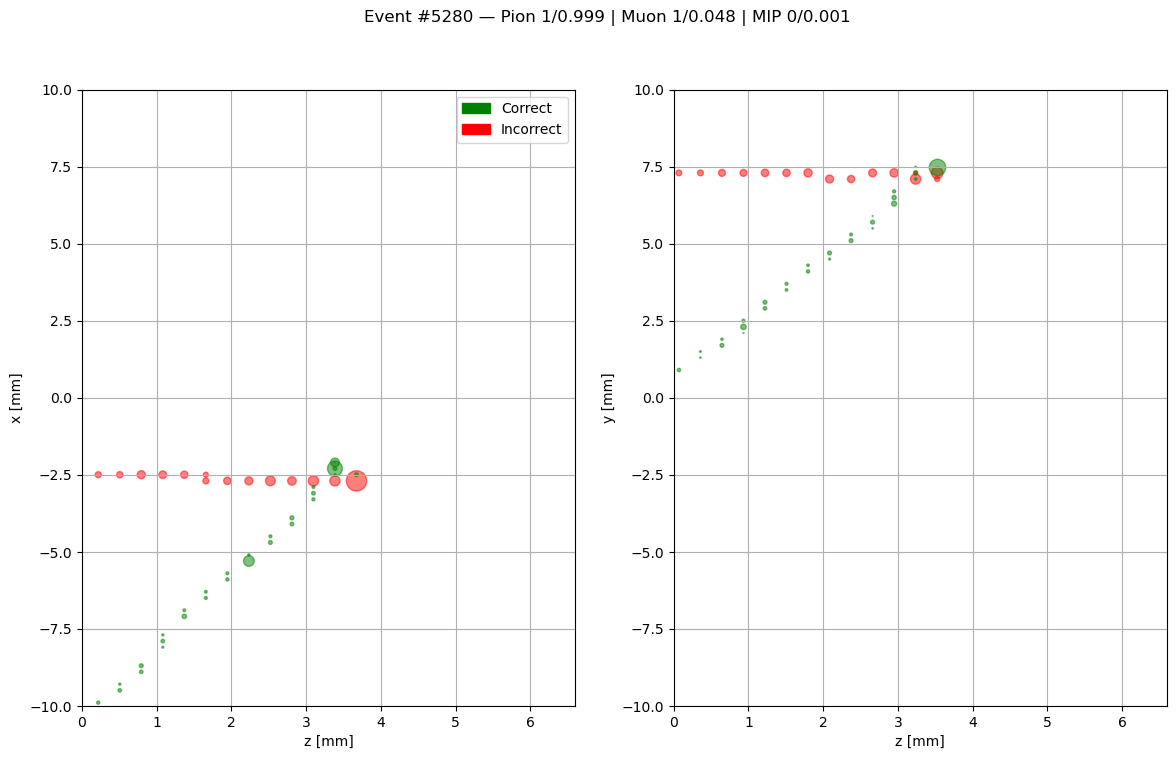

Raw probabilities: [0.999 0.048 0.001]
Ground truth   : [1.0, 1.0, 0.0]


In [72]:
visualize_failed_event_prediction_mc_dropout(
    selected_event_idx=39,
    model=main_model,
    dataset=main_dataset,
    failures=main_failures,
    fail_eventNum2groups=main_fail_eventNum2groups,
    eventTimeGroupsCleaned=mainTimeGroups,
    eventIndexCleaned=mainEventIndex,
    threshold=0.5,
    num_samples=5
)

In [253]:
print(len(main_failures)/100000)

In [27]:
torch.save(main_model.state_dict(), '/mnt/e/testML/groupClassifierV11.pth')

In [ ]:
#main_model = GroupClassifier(in_channels=5, hidden_channels=200)
#main_model.load_state_dict(torch.load('/mnt/e/testML/groupClassifierV8.pth'))

In [85]:
truth = []
pionness = []
muonness = []
MIPness = []
loss = []

pion_masks = []
muon_masks = []
mip_masks = []
pimu_masks = []


for i in range(20):
    temp_history = main_history[i]
    loss.append(temp_history["loss"])
    temp_truth = temp_history["truth"]
    temp_predictions = temp_history["predictions"]

    flat_truth = np.concatenate(temp_truth, axis=0)
    flat_pred = np.concatenate(temp_predictions, axis=0)

    truth.append(flat_truth)
    pionness.append(flat_pred[:, 0])
    muonness.append(flat_pred[:, 1])
    MIPness.append(flat_pred[:, 2])

    pion_vector = np.array([1, 0, 0])
    muon_vector = np.array([0, 1, 0])
    mip_vector = np.array([0, 0, 1])
    pimu_vector = np.array([1, 1, 0])

    pion_mask = np.all(flat_truth == pion_vector, axis=1)
    muon_mask = np.all(flat_truth == muon_vector, axis=1)
    mip_mask = np.all(flat_truth == mip_vector, axis=1)
    pimu_mask = np.all(flat_truth == pimu_vector, axis=1)

    pion_masks.append(pion_mask)
    muon_masks.append(muon_mask)
    mip_masks.append(mip_mask)
    pimu_masks.append(pimu_mask)







In [50]:
def sigmoid_numpy(x):
    return 1 / (1 + np.exp(-x))

In [94]:
eq = np.array([1, 0, 1])
ew = np.all(truth[0] == eq, axis=1)
print(ew)

[False False False ... False False False]


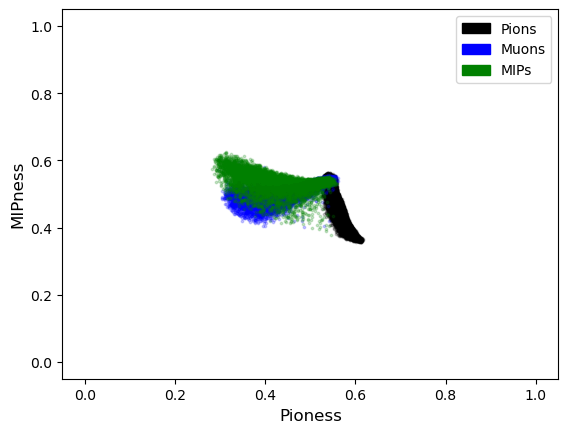

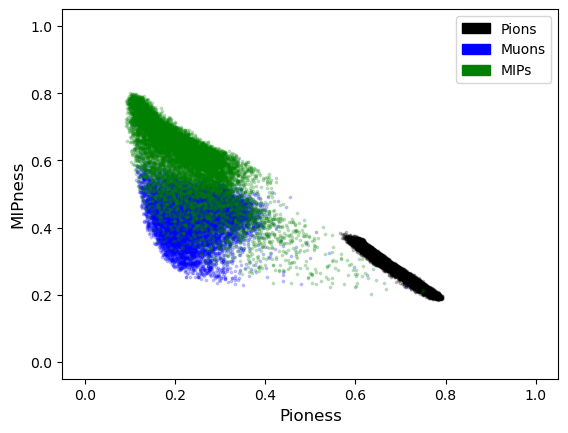

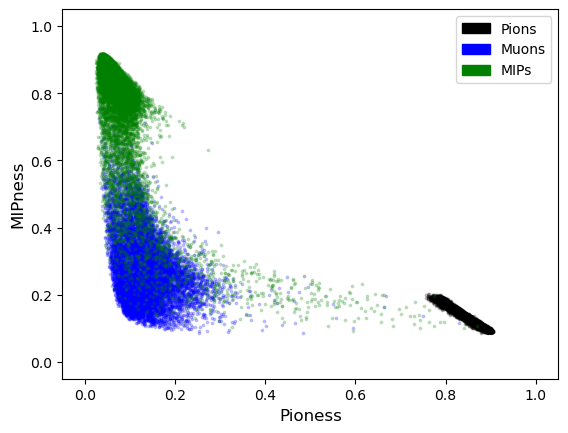

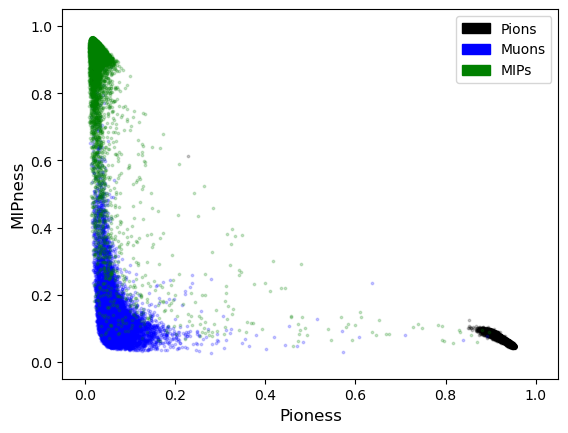

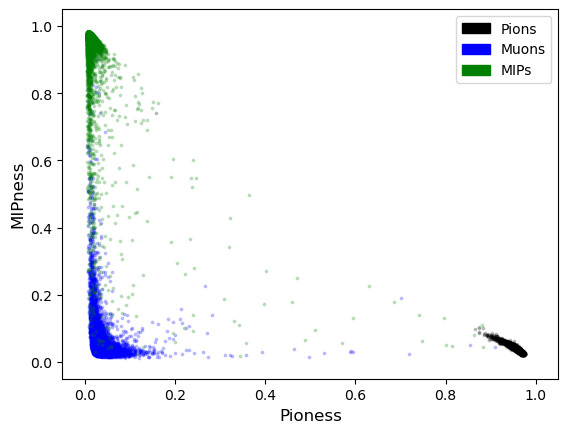

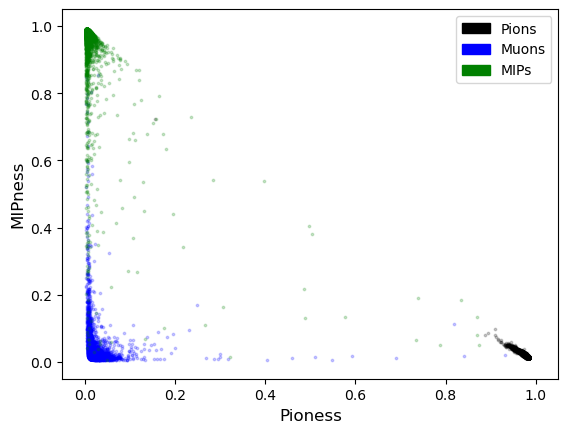

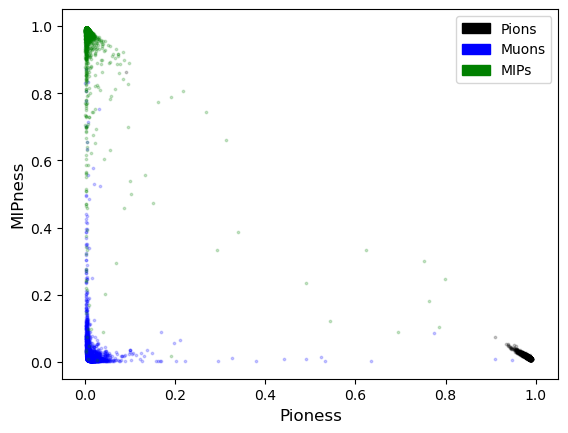

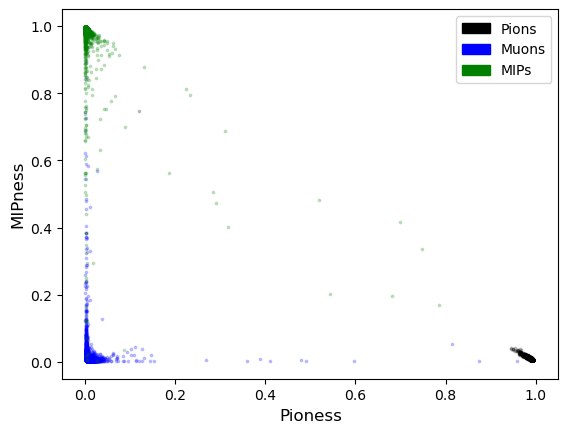

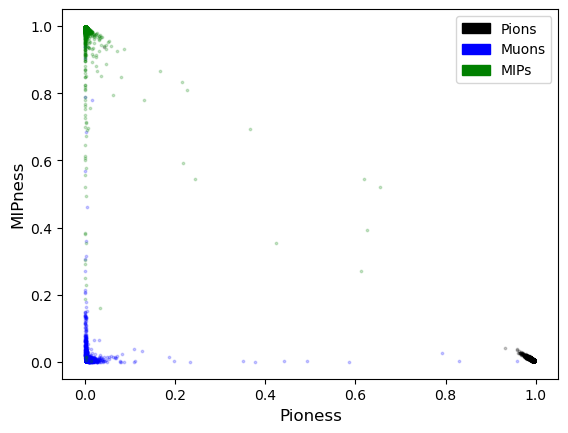

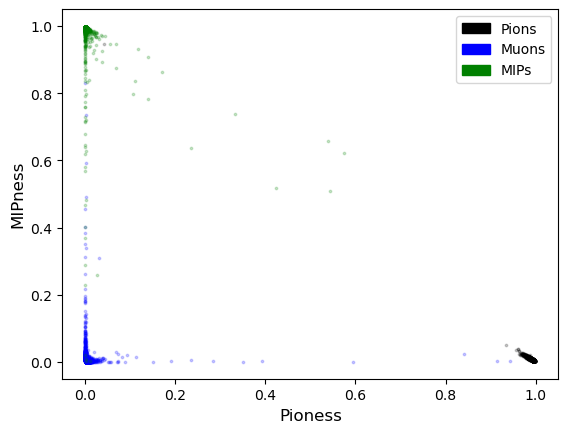

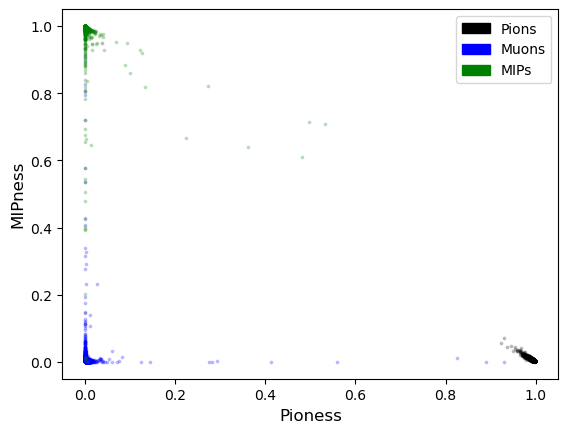

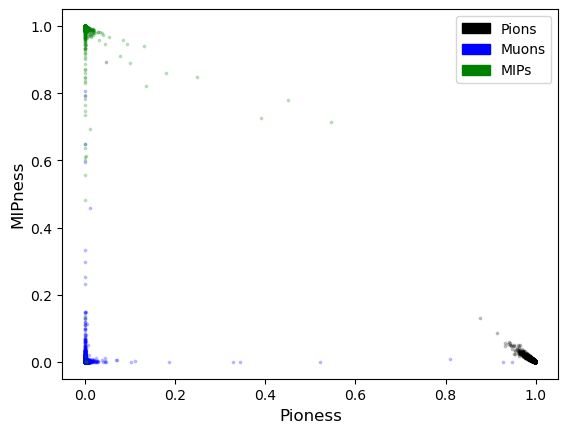

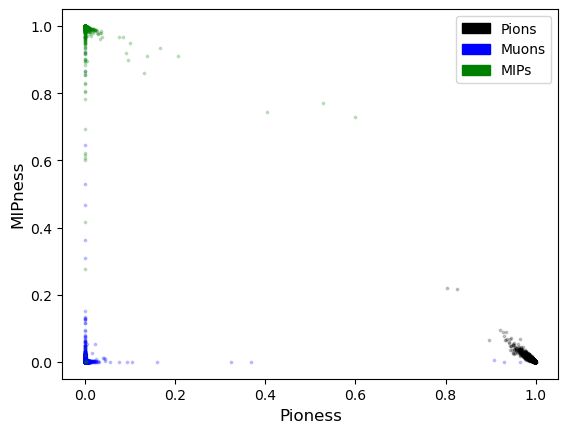

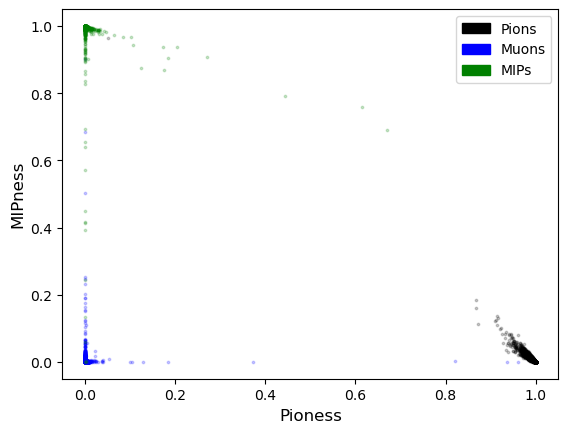

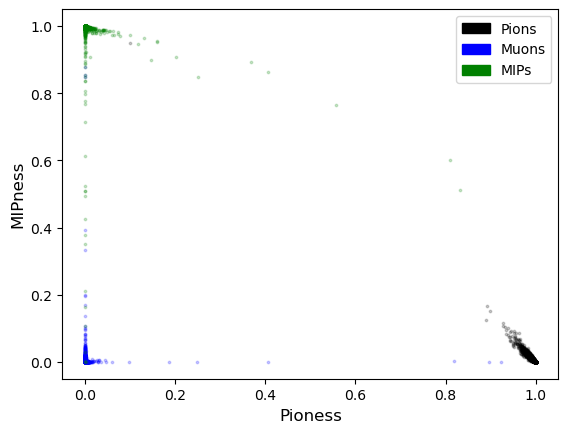

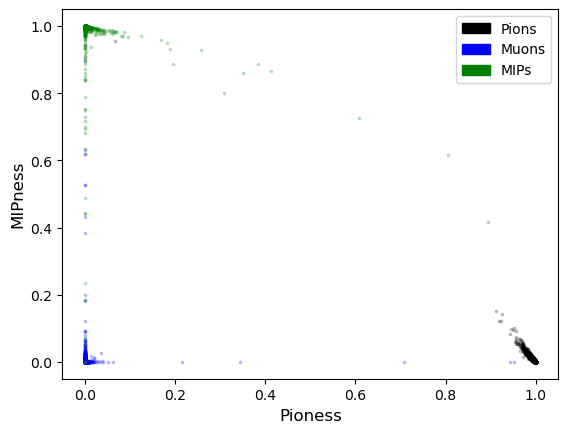

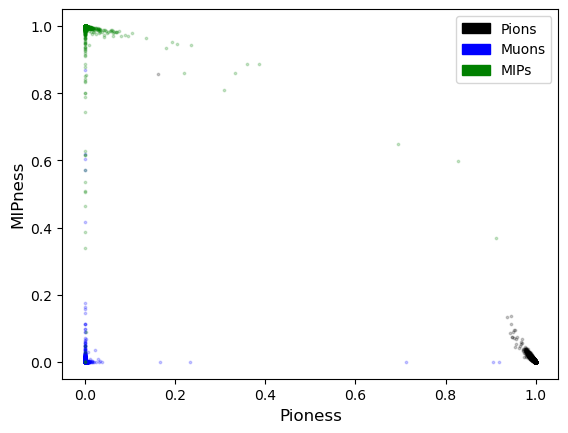

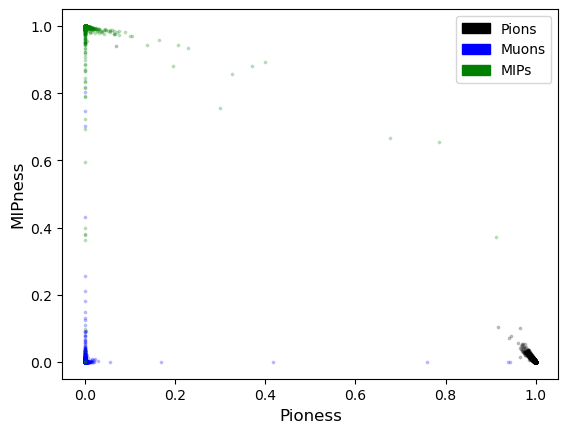

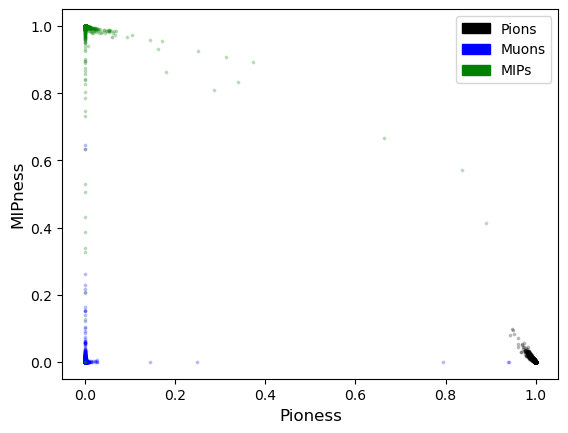

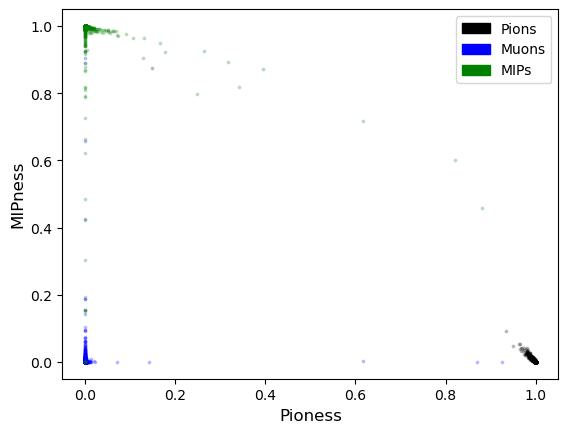

In [129]:

for epoch in range(20):

    plt.scatter(sigmoid_numpy(np.array(pionness[epoch][pion_masks[epoch]])),sigmoid_numpy(np.array(MIPness[epoch][pion_masks[epoch]])),s=3, alpha=0.2, color="black")
    plt.scatter(sigmoid_numpy(np.array(pionness[epoch][muon_masks[epoch]])),sigmoid_numpy(np.array(MIPness[epoch][muon_masks[epoch]])),s=3, alpha=0.2,color="blue")
    plt.scatter(sigmoid_numpy(np.array(pionness[epoch][mip_masks[epoch]])),sigmoid_numpy(np.array(MIPness[epoch][mip_masks[epoch]])),s=3, alpha=0.2, color="green")
    #plt.scatter(sigmoid_numpy(np.array(pionness[epoch][pimu_mask[epoch]])),sigmoid_numpy(np.array(MIPness[epoch][pimu_mask[epoch]])),s=0.5, alpha=0.5)
    plt.ylim(-0.05,1.05)
    plt.xlim(-0.05,1.05)
    plt.xlabel("Pioness", fontsize=12)
    plt.ylabel("MIPness", fontsize=12)

    pion_patch = mpatches.Patch(color='black', label='Pions')
    muon_patch = mpatches.Patch(color='blue', label='Muons')
    mip_patch = mpatches.Patch(color='green', label='MIPs')
    plt.legend(handles=[pion_patch, muon_patch, mip_patch])
    plt.savefig(f'/mnt/c/Users/obbee/OneDrive/Pictures/plots/epoch{epoch+1}_scoring.png', dpi=300)
    plt.show()

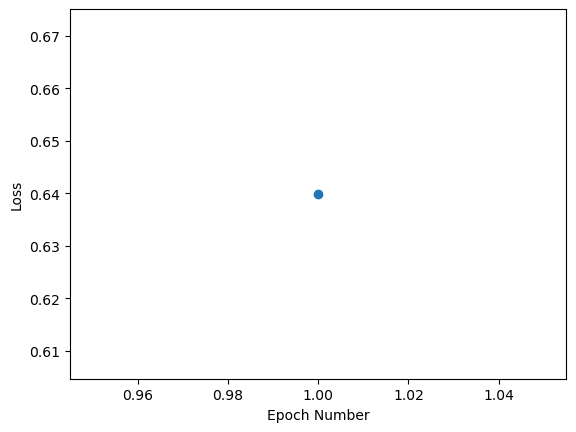

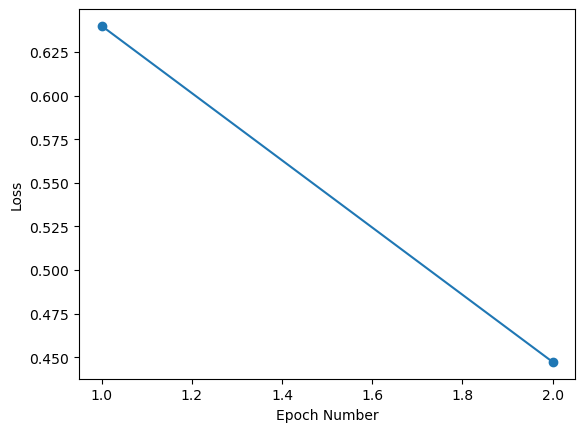

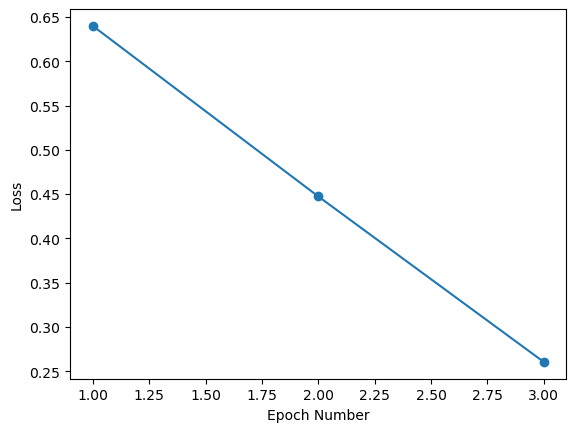

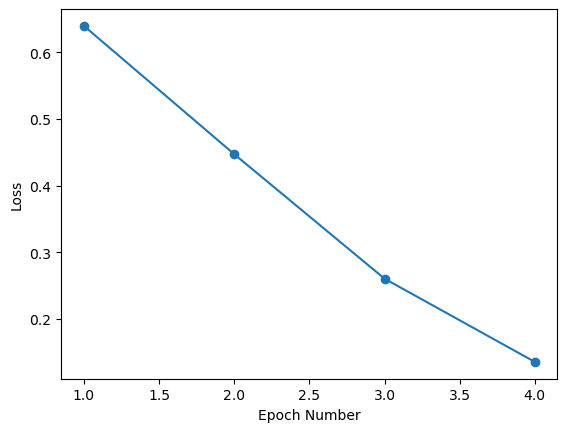

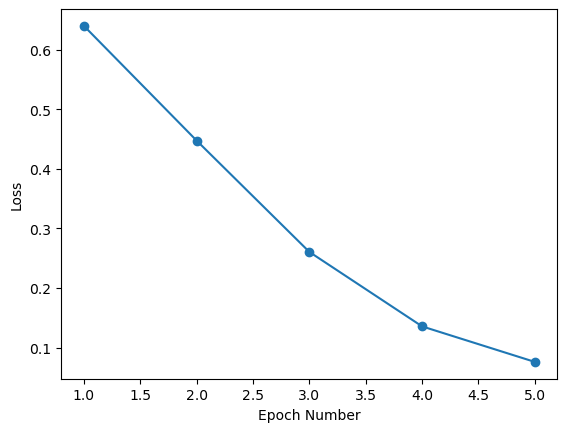

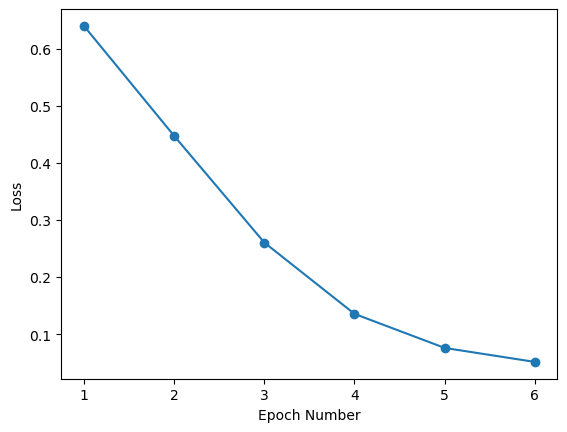

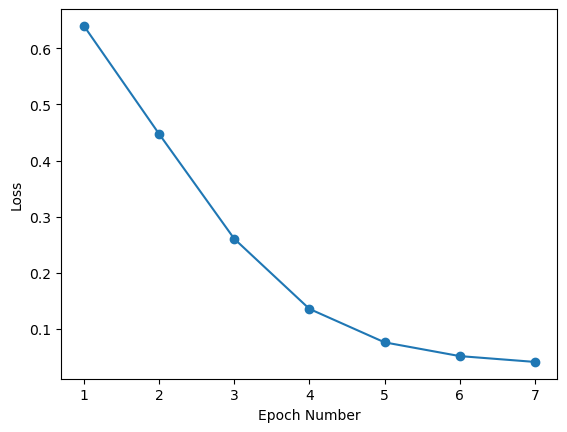

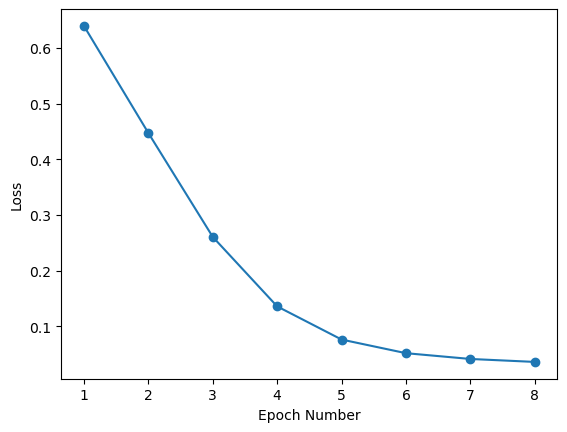

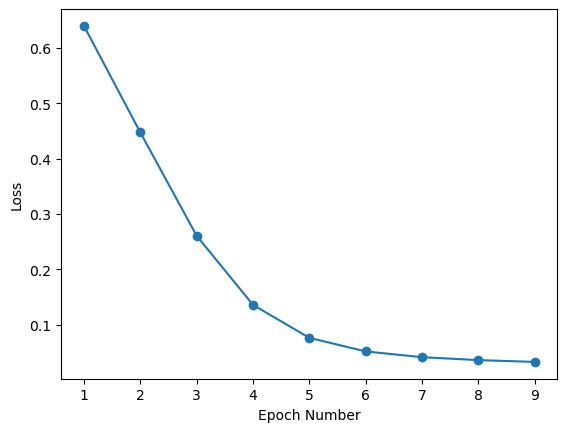

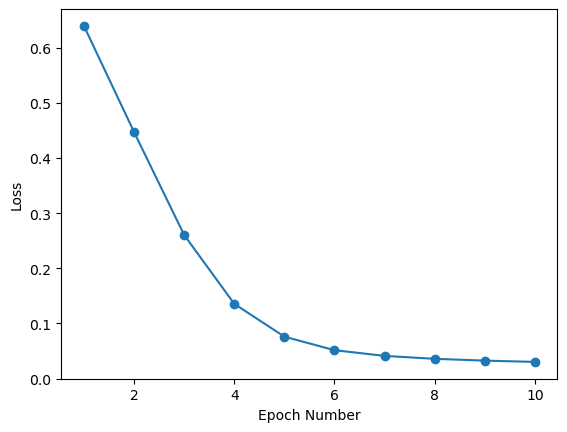

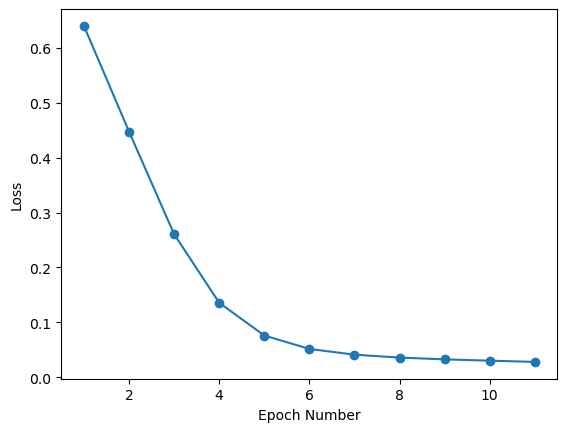

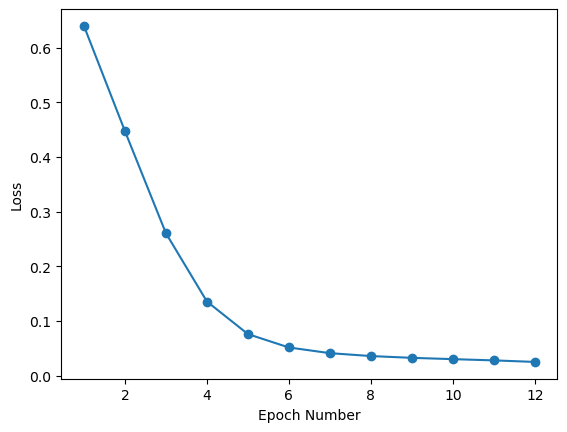

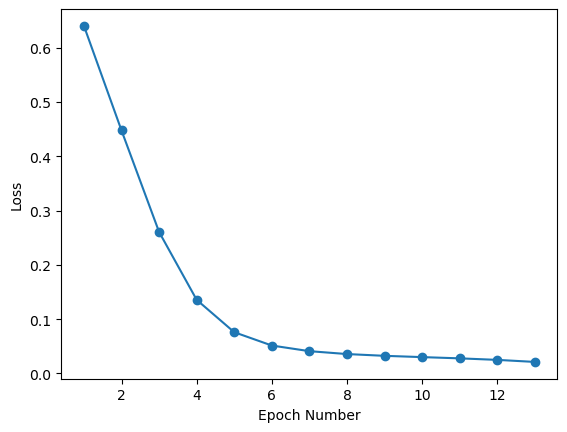

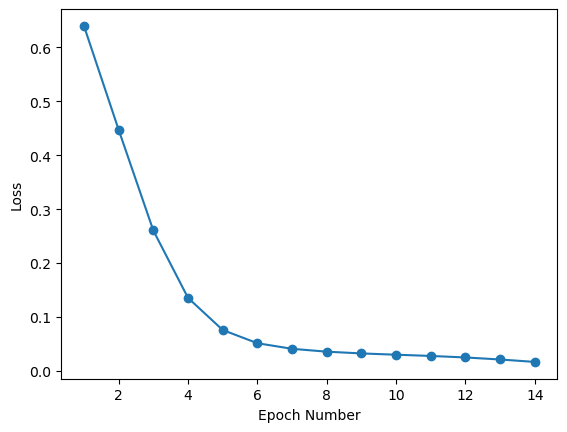

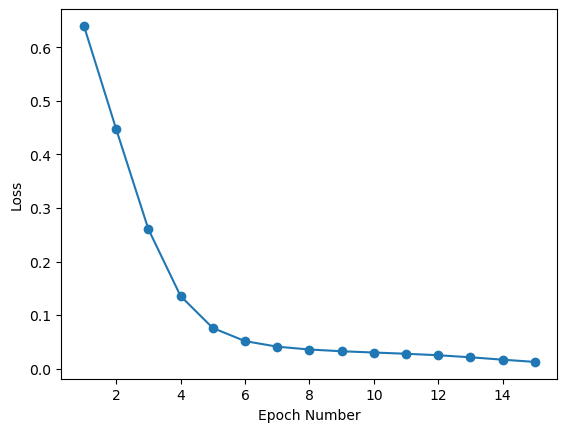

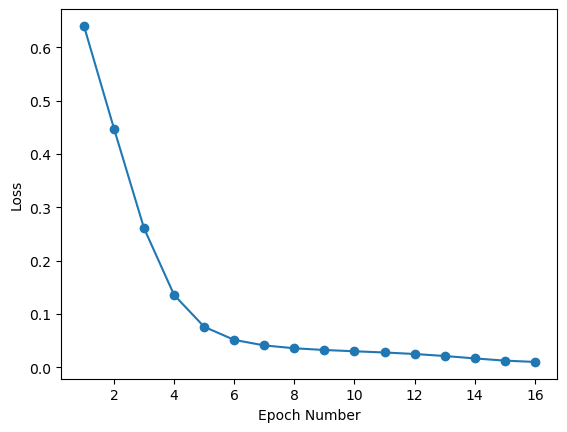

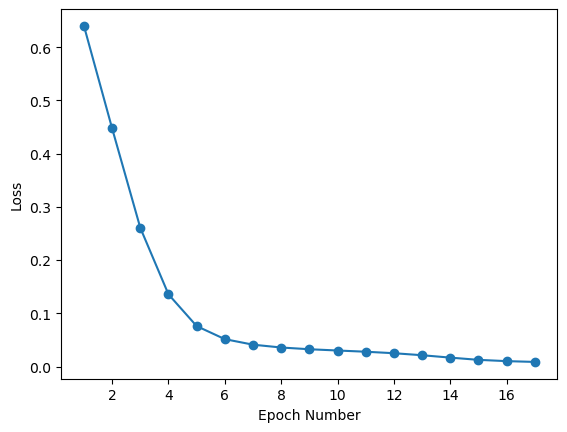

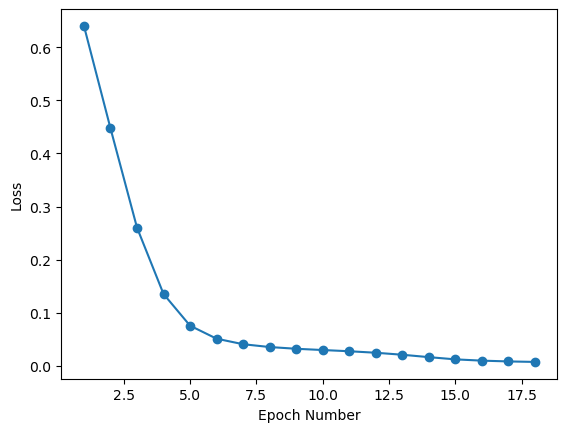

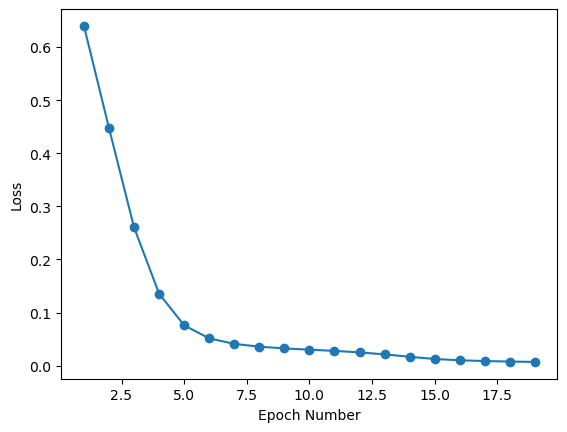

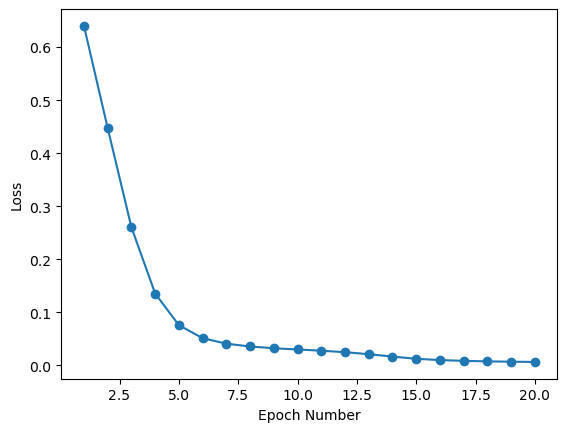

In [143]:
for epoch in range(20):
    plt.plot(range(1,epoch+2),np.array(loss[0:epoch+1]), marker='o')
    plt.ylabel("Loss")
    plt.xlabel("Epoch Number")
    plt.show()


In [152]:
num_epochs = 20
frame_filenames = []

# Setup the figure and two subplots side-by-side
# fig: the overall figure object
# (ax_scatter, ax_loss): a tuple of axes objects for each subplot
fig, (ax_scatter, ax_loss) = plt.subplots(1, 2, figsize=(14, 6)) # Adjust figsize as needed

# Fixed legend patches for the scatter plot
pion_patch = mpatches.Patch(color='black', label='Pions')
muon_patch = mpatches.Patch(color='blue', label='Muons')
mip_patch = mpatches.Patch(color='green', label='MIPs')


for epoch in range(num_epochs): # Assuming num_epochs is defined, e.g., 20

    # --- Update Scatter Plot (Left Subplot) ---
    ax_scatter.clear() # Clear the previous epoch's plot on this axis
    ax_scatter.scatter(sigmoid_numpy(np.array(pionness[epoch][pion_masks[epoch]])),
                       sigmoid_numpy(np.array(MIPness[epoch][pion_masks[epoch]])),
                       s=3, alpha=0.5, color="black", label='Pions')
    ax_scatter.scatter(sigmoid_numpy(np.array(pionness[epoch][muon_masks[epoch]])),
                       sigmoid_numpy(np.array(MIPness[epoch][muon_masks[epoch]])),
                       s=3, alpha=0.5, color="blue", label='Muons')
    ax_scatter.scatter(sigmoid_numpy(np.array(pionness[epoch][mip_masks[epoch]])),
                       sigmoid_numpy(np.array(MIPness[epoch][mip_masks[epoch]])),
                       s=3, alpha=0.5, color="green", label='MIPs')
    
    ax_scatter.set_ylim(-0.05, 1.05)
    ax_scatter.set_xlim(-0.05, 1.05)
    ax_scatter.set_xlabel("Pionness", fontsize=12)
    ax_scatter.set_ylabel("MIPness", fontsize=12)
    ax_scatter.set_title(f'Epoch {epoch+1} - Particle Classification')
    ax_scatter.legend(handles=[pion_patch, muon_patch, mip_patch], loc='upper right')
    ax_scatter.grid(True, linestyle='--', alpha=0.6) # Add grid for clarity


    # --- Update Loss Plot (Right Subplot) ---
    ax_loss.clear() # Clear the previous epoch's plot on this axis
    # Plot loss up to the current epoch
    ax_loss.plot(range(1, epoch + 2), np.array(loss[0 : epoch + 1]), marker='o', linestyle='-', color='purple')
    
    ax_loss.set_ylabel("Loss", fontsize=12)
    ax_loss.set_xlabel("Epoch Number", fontsize=12)
    ax_loss.set_title('Training Loss Over Epochs')

    
    # Crucial for GIF consistency: set fixed y-limits for the loss plot
    # These limits should encompass the full range of your expected loss values.
    # Adjust min_loss_val and max_loss_val based on your actual data.
    min_loss_val = np.min(loss) * 0.9 if len(loss) > 0 else -0.05
    max_loss_val = np.max(loss) * 1.1 if len(loss) > 0 else 1.05
    ax_loss.set_ylim(-0.025, max_loss_val)
    
    # Also set a fixed x-limit to ensure the axis doesn't jump
    ax_loss.set_xlim(0.5, num_epochs + 0.5) # From 0.5 to num_epochs + 0.5
    ax_loss.grid(True, linestyle='--', alpha=0.6)

    # --- Save Frame ---
    # Create a unique filename for each epoch's plot
    filename = os.path.join('/mnt/c/Users/obbee/OneDrive/Pictures/plots/', f'epoch_{epoch:03d}_training.png') # e.g., epoch_000.png, epoch_001.png
    plt.savefig(filename, dpi=300, bbox_inches='tight') # Save with good resolution and no extra whitespace
    frame_filenames.append(filename)

# It's good practice to close the figure after saving all frames to free memory
#plt.show()
plt.close(fig)


In [156]:
gif_path = '/mnt/c/Users/obbee/OneDrive/Pictures/plots/training_animation.gif'
with imageio.get_writer(gif_path, mode='I', fps=2) as writer: # Adjust fps (frames per second) as desired
    for filename in frame_filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        #os.remove(filename)

/tmp/ipykernel_82748/1301293303.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [90]:
from matplotlib.colors import LogNorm
def plot_confusion_matrix(data, class_labels=None, title='Confusion Matrix'):
    """
    Plots a 3x3 confusion matrix from a list of lists.
    
    Parameters:
    - data: List of 3 lists, each with 3 numeric entries.
    - class_labels: Optional list of 3 strings to use as axis labels.
    - title: Optional title for the plot.
    """
    if len(data) != 3 or any(len(row) != 3 for row in data):
        raise ValueError("Input must be a 3x3 list of lists.")
    
    matrix = np.array(data)

    fig, ax = plt.subplots()
    im = ax.imshow(matrix, cmap='Greys_r',norm=LogNorm(vmin=matrix[matrix > 0].min(), vmax=matrix.max()), alpha=0.0)

    # Add annotations
    for i in range(3):
        for j in range(3):
            ax.text(j, i, f"{matrix[i, j]}", 
                    ha='center', va='center', color='black', fontsize=12)

    # Axis labels
    if class_labels is None:
        class_labels = ['Class 0', 'Class 1', 'Class 2']

    ax.set_xticks(np.arange(3))
    ax.set_yticks(np.arange(3))
    ax.set_xticklabels(['True Positive', 'False Positive', 'False Negative'])
    ax.set_yticklabels(class_labels)

    #ax.set_xlabel('Classifications')
    #ax.set_ylabel('True Label')
    ax.set_title(title)

    # Set major ticks at the center of each cell
    ax.set_xticks(np.arange(3))
    ax.set_yticks(np.arange(3))

    # Set minor ticks to draw grid lines on the borders
    ax.set_xticks(np.arange(3+1)-0.5, minor=True)
    ax.set_yticks(np.arange(3+1)-0.5, minor=True)

    # Draw gridlines based on minor ticks
    ax.grid(which="minor", color="black", linestyle='-', linewidth=1)

    # Disable tick marks
    ax.tick_params(which="minor", bottom=False, left=False)

    #fig.colorbar(im)
    #plt.tight_layout()
    plt.show()

In [ ]:
plot_confusion_matrix(data, class_labels=['Pion', 'Muon', 'Positron'], title="Classifier Accuracy")